# MNIST in jax

In this notebook I'll be implementing an MNIST model using Jax.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as npr

import json
import time
import numpy as np
import jax.numpy as jnp
from jax import jit, grad, random, nn
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, Relu, LogSoftmax

from torchvision.datasets import MNIST

# Set random seeds
rng = random.PRNGKey(0)
npr.seed(1234)

## Viewing the data

To start, we'll take a look at some of the samples just to make sure we understand the data.

In [2]:
mnist = MNIST(root='../data/mnist', download=True)
images = jnp.array(mnist.data)
targets = jnp.array(mnist.targets)

In [3]:
# Collect the target indices and shuffle them
idxs = np.arange(targets.shape[0])
npr.shuffle(idxs)

# Do train-test-validation split
num_train_samples = round(targets.shape[0] * 0.7)
num_valid_samples = round(targets.shape[0] * 0.2)
num_test_samples  = round(targets.shape[0] * 0.1)

train_sample = idxs[:num_train_samples]
valid_sample = idxs[num_train_samples:num_train_samples+num_valid_samples]
test_sample  = idxs[-num_test_samples:]

train_images = images[train_sample, :, :]
valid_images = images[valid_sample, :, :]
test_images  = images[test_sample , :, :]

train_labels = nn.one_hot(targets[train_sample], num_classes=10)
valid_labels = nn.one_hot(targets[valid_sample], num_classes=10)
test_labels  = nn.one_hot(targets[test_sample],  num_classes=10)

In [4]:
print(f"Train samples:\t\t{train_labels.shape[0]:,} images")
print(f"Validation samples:\t{valid_labels.shape[0]:,} images")
print(f"Test samples:\t\t{test_labels.shape[0]:,} images")

Train samples:		42,000 images
Validation samples:	12,000 images
Test samples:		6,000 images


In [5]:
# Check that the train-test-validation split partitions the mnist data properly
assert np.all(np.sort(np.concatenate([train_sample, valid_sample, test_sample])) == np.arange(targets.shape[0]))

In [6]:
train_images.shape

(42000, 28, 28)

In [7]:
train_labels.shape

(42000, 10)

## See an image

To make sure we understand the data correctly, we take a look at an image here:

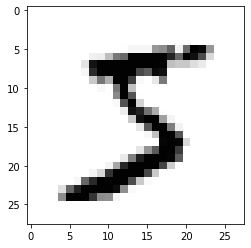

In [8]:
plt.imshow(images[0,:,:], cmap='Greys')

### See a few images

Next we take a look at a random sample of images, along with the targets. This way we can see what the data looks like, and get a sense for how good the labelling is.

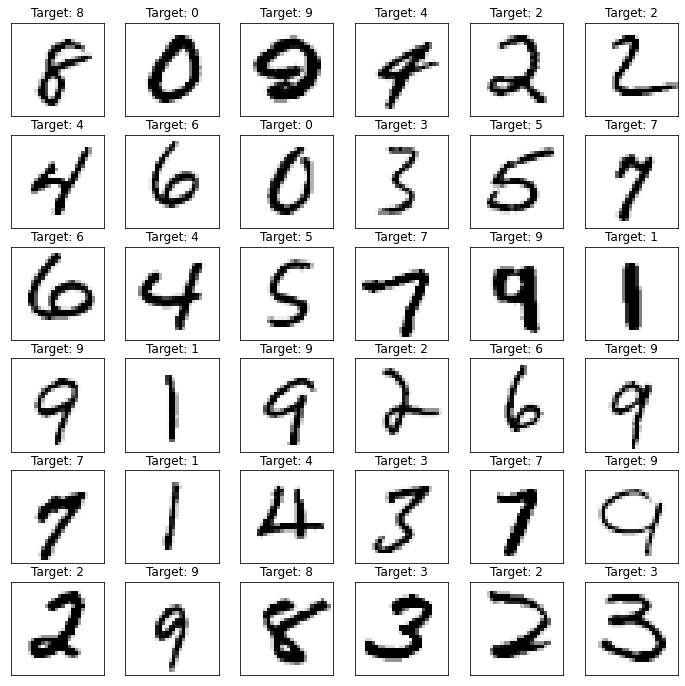

In [9]:
import itertools as it
from random import choice
grid_size = 6
f, ax = plt.subplots(grid_size, grid_size, figsize=(12,12))
for row, col in it.product(range(grid_size),range(grid_size)):
    # Choose an image index at random
    idx = choice(range(train_images.shape[0]))
    
    # Plot the image at the given row, col
    ax[row, col].imshow(train_images[idx,:,:], cmap='Greys')
    
    # Set title and tidy up image
    ax[row, col].set_title(f'Target: {jnp.argmax(train_labels[idx])}')
    ax[row, col].axes.xaxis.set_ticks([])
    ax[row, col].axes.yaxis.set_ticks([])
    ax[row, col].axes.xaxis.set_ticklabels([])
    ax[row, col].axes.yaxis.set_ticklabels([])

### Check out the target frequencies

Here we count the label frequencies in the dataset. This will tell us if the data has imbalance issues.

<AxesSubplot:>

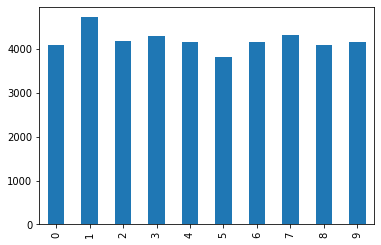

In [10]:
pd.Series(jnp.argmax(train_labels, axis=1)).value_counts().sort_index().plot(kind='bar')

We can see that the target classes are fairly balanced.

## Train a simple model

Now that we've taken a look at the data, we can try training a model.

In [11]:
# Set hyperparameters
step_size = 0.001
num_epochs = 10
batch_size = 128
momentum_mass = 0.9

init_random_params, predict = stax.serial(
    Dense(1024), Relu,
    Dense(1024), Relu,
    Dense(10), LogSoftmax)

# Calculate batch sizes
num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

In [12]:
train_images.reshape(num_train, 28 * 28).shape

(42000, 784)

In [13]:
def data_stream(flatten=True):
    rng = npr.RandomState(0)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            batch_labels = train_labels[batch_idx]
            if flatten:
                batch_images = train_images[batch_idx, :, :].reshape(len(batch_idx), 28 * 28)
            yield batch_images, batch_labels

batches = data_stream()

In [14]:
opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

In [15]:
image_flatten = lambda x: x.reshape(x.shape[0], x.shape[1] * x.shape[2])

def loss(params, batch):
    inputs, targets = batch
    preds = predict(params, inputs)
    return -jnp.mean(jnp.sum(preds * targets, axis=1))

def accuracy(params, batch):
    inputs, targets = batch
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(predict(params, inputs), axis=1)
    return jnp.mean(predicted_class == target_class)

@jit
def update(i, opt_state, batch):
    params = get_params(opt_state)
    return opt_update(i, grad(loss)(params, batch), opt_state)

In [16]:
_, init_params = init_random_params(rng, (-1, 28 * 28))
opt_state = opt_init(init_params)
itercount = it.count()

In [17]:
metrics = pd.DataFrame({}, columns=['epoch', 'epoch_time', 'train_acc', 'test_acc'])

for epoch in range(num_epochs):
    start_time = time.time()
    for _ in range(num_batches):
        opt_state = update(next(itercount), opt_state, next(batches))
    epoch_time = time.time() - start_time

    params = get_params(opt_state)
    train_acc = accuracy(params, (image_flatten(train_images), train_labels))
    test_acc = accuracy(params, (image_flatten(test_images), test_labels))
    
    metrics_dict = {
        'epoch': epoch,
        'epoch_time': round(epoch_time, 4),
        'train_acc': round(float(train_acc), 4),
        'test_acc': round(float(test_acc), 4)
    }
    metrics = pd.concat([metrics, pd.DataFrame.from_dict([metrics_dict])])
    print('\r' + json.dumps(metrics_dict), end='')

{"epoch": 9, "epoch_time": 0.8184, "train_acc": 0.9998, "test_acc": 0.9692}

## Observe metrics

In [18]:
metrics

,epoch,epoch_time,train_acc,test_acc
0,0,2.8652,0.9529,0.9425
0,1,0.8331,0.972,0.955
0,2,0.8152,0.9802,0.9587
0,3,0.8125,0.9894,0.9648
0,4,0.8333,0.9938,0.9658
0,5,0.8228,0.9962,0.9673
0,6,0.8325,0.9982,0.9673
0,7,0.8513,0.9991,0.9677
0,8,0.8221,0.9998,0.969
0,9,0.8184,0.9998,0.9692


/usr/local/lib/python3.9/dist-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<AxesSubplot:xlabel='epoch'>

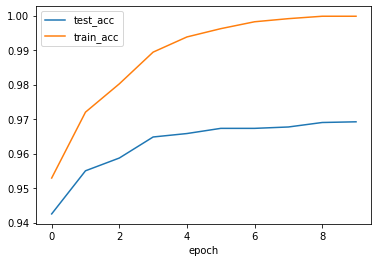

In [19]:
metrics.plot(x = 'epoch', y = ['test_acc', 'train_acc'])

## Diagnostics

Now, we calculate a bunch of diagnostics using our trained model.